# Computing the core Čech filtration for a fixed $k$

In this notebook, we show how to compute the persistent homology of the core Čech filtration in the simplest case where $k$ is fixed. For $k=1$ we demonstrate that the core Čech filtration is indeed equivalent to the usual Čech filtration by comparing it to the $\alpha$-complex. Furthermore, we compute the persistent homology of a noisy circle for different values of $k$ using the core Čech filtration.

In [1]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets import sample_circle, sample_rectangle

In [2]:
rng = np.random.default_rng(seed=0)

We define a function to construct the core Čech filtration from a point cloud for a fixed $k$:

In [3]:
def core_cech(points, k, max_dim=1, return_squared=False):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k)
    if k > 1:
        k_core_distances = k_core_distances[:, -1]
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            face_list = list(face)
            max_core = max(k_core_distances[face_list])
            squared_radius = Miniball(X[face_list]).squared_radius()
            if return_squared:
                filtration_value = max(squared_radius, max_core**2)
            else:
                filtration_value = max(math.sqrt(squared_radius), max_core)
            st.insert(face, filtration_value)
    return st         

### Comparing to the $\alpha$-complex

We let $X=Z\cup Y$ where $Z$ is a sample from the unit circle with noise added from a normal distribution, and $Y$ is uniformly sampled from $[-1, 1]^2$.

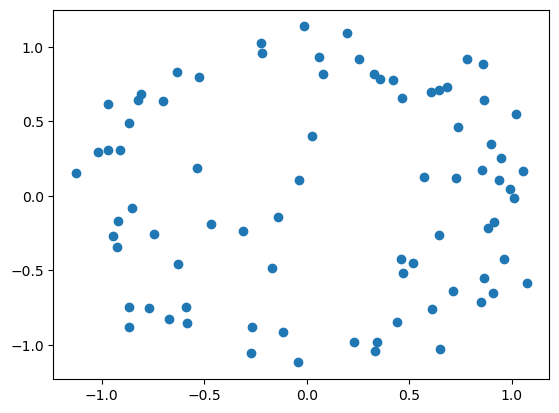

In [4]:
N = 40
M = 40
Z = sample_circle(N, rng, variance=0.01)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T)
plt.show()

In [8]:
st_core = core_cech(points=X, max_dim=2, k=1, return_squared=True)
st_alpha = gudhi.AlphaComplex(points=X, precision = 'exact').create_simplex_tree()

Note that since GUDHI's `AlphaComplex` returns squared filtration values, we need to set `return_square=True` when calling `core_cech`.

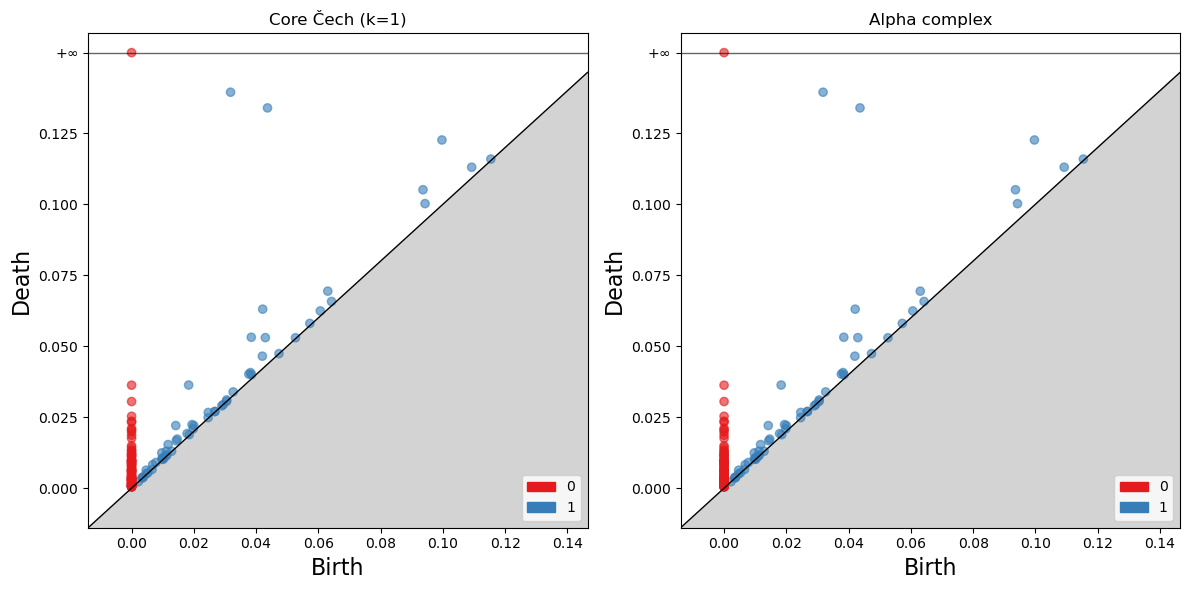

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[0])
gudhi.plot_persistence_diagram(st_alpha.persistence(), axes=axs[1])
axs[0].set_title("Core Čech (k=1)")
axs[1].set_title("Alpha complex")
fig.tight_layout()
plt.show()

### Different values of $k$

We now compute the core Čech filtration for some different values of $k$ and plot the corresponding persistence diagrams.

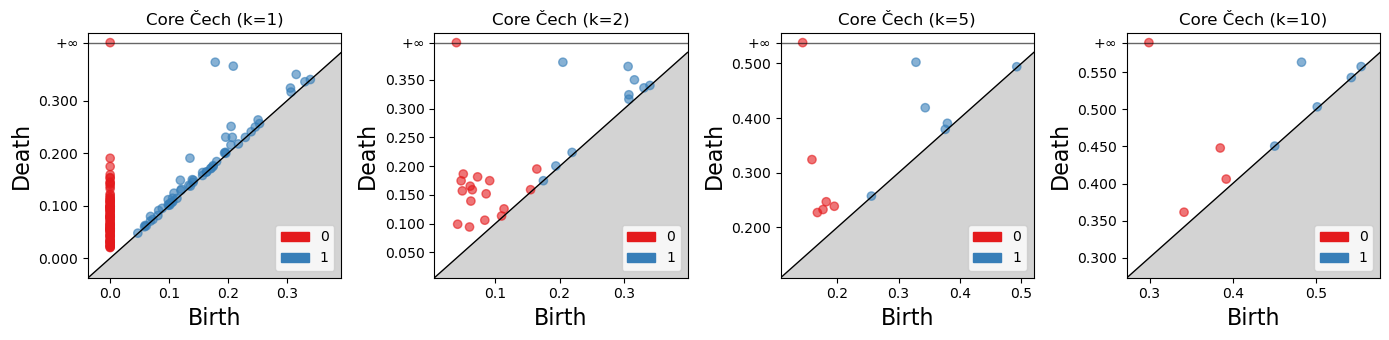

In [10]:
ks = [1, 2, 5, 10]

fig, axs = plt.subplots(ncols=len(ks), figsize=(14, 14 / len(ks)))
for i, k in enumerate(ks):
    st_core = core_cech(points=X, max_dim=2, k=k)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"Core Čech (k={k})")
fig.tight_layout()
plt.show()